# Federated Variational Autoencoders in biomedical data
Here, an example of a variability analysis using a Multi-channel variational autoencoder proposed by [Antelmi _et_ al](http://proceedings.mlr.press/v97/antelmi19a.html).

In [1]:
import copy
import pandas as pd

import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
N_CENTERS = 4
N_ROUNDS = 50   # Number of iterations between all the centers training and the aggregation process.

N_EPOCHS = 100   # Number of epochs before aggregating
BATCH_SIZE = 48
LR = 1e-2       # Learning rate

We define a set of functions to distribute our dataset across multiple centers (`split_iid`) and for doing federated averaging (`federated_averaging`).

In [3]:
import numpy as np
def split_iid(df, n_centers):
    """ Split pandas DataFrame dataset randomly into n_centers """
    data = df.sample(frac=1)  # Shuffle dataset
    data =  np.array_split(data, n_centers)
    return data

In [4]:
def federated_averaging(models, n_obs_per_client):
    assert len(models) > 0, 'An empty list of models was passed.'
    assert len(n_obs_per_client) == len(models), 'List with number of observations must have ' \
                                                 'the same number of elements that list of models.'

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

## Federating dataset

In [5]:
csv = 'https://gitlab.inria.fr/ssilvari/flhd/-/raw/master/heterogeneous_data/pseudo_adni.csv?inline=false'
df = pd.read_csv(csv)

df.sample()

,SEX,AGE,PTEDUCAT,CDRSB.bl,ADAS11.bl,MMSE.bl,RAVLT.immediate.bl,RAVLT.learning.bl,RAVLT.forgetting.bl,FAQ.bl,WholeBrain.bl,Ventricles.bl,Hippocampus.bl,MidTemp.bl,Entorhinal.bl,APOE4,ABETA.MEDIAN.bl,PTAU.MEDIAN.bl,TAU.MEDIAN.bl
669,1.0,69.0,14.945415,0,7,27.0,28.482003,3.0,3.349521,0,0.687166,0.007506,0.005003,0.013367,0.002208,0,200.999667,9.887908,7.109941


In [6]:
df.columns

Index(['SEX', 'AGE', 'PTEDUCAT', 'CDRSB.bl', 'ADAS11.bl', 'MMSE.bl',
       'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl',
       'FAQ.bl', 'WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl',
       'MidTemp.bl', 'Entorhinal.bl', 'APOE4', 'ABETA.MEDIAN.bl',
       'PTAU.MEDIAN.bl', 'TAU.MEDIAN.bl'],
      dtype='object')

In [7]:
df["RAVLT.learning.bl"].value_counts()

4.0     153
5.0     128
3.0     117
6.0     112
0.0     100
2.0      98
1.0      96
7.0      90
8.0      62
9.0      31
10.0     10
12.0      2
11.0      1
Name: RAVLT.learning.bl, dtype: int64

Now, `federated_dataset` is a list of subsets of the main dataset.

In [8]:
federated_dataset = split_iid(df, n_centers=N_CENTERS)
print('Number of centers:', len(federated_dataset))

Number of centers: 4


Finally, we must parse each dataframe in the form of a tensor Dataset grouping variables in 5 channels:
* Volumetric data
* Demographics
* Cognition
* Genetics: Apolipoprotein E (APOE)
* Fluid biomarkers: Amyloid beta (Abeta) and Tau concentrations in the Cerebrospinal fluid (CSF).

In [9]:
def get_channels():
    
    channel_1 = ['WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
    channel_2 = ['SEX', 'AGE', 'PTEDUCAT']
    channel_3 = ['CDRSB.bl', 'ADAS11.bl', 'MMSE.bl', 'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl', 'FAQ.bl']
    channel_4 = ['APOE4']
    channel_5 = ['ABETA.MEDIAN.bl', 'PTAU.MEDIAN.bl', 'TAU.MEDIAN.bl']
    return channel_1, channel_2, channel_3, channel_4, channel_5

def get_data_as_multichannel_tensor_dataset(df):
    """Takes a dataframe, splits it into multiple channels and parse each channel as a tensor"""
    channel_1, channel_2, channel_3, channel_4, channel_5 = get_channels()
    
    df = (df - df.mean())/df.std()
    def as_tensor(cols):
        return torch.tensor(df[cols].values).float()
    
    return [as_tensor(channel_1), as_tensor(channel_2), as_tensor(channel_3), as_tensor(channel_4), as_tensor(channel_5)]

## Defining and distributing a model: Variational Autoencoder
In this excercise we will use the Multi-channel Variational Autoencoder proposed by Antelmi _et_ al.

In [10]:
!pip install -q git+https://gitlab.inria.fr/epione_ML/mcvae.git

In [11]:
from mcvae.models import Mcvae, ThreeLayersVAE, VAE

First, it is necessary to define a model.

In [12]:
dummy_data = [torch.zeros_like(x) for x in get_data_as_multichannel_tensor_dataset(df.sample())]  # Dummy data to initialize the input layer size
lat_dim = 1  # Size of the latent space for this autoencoder
vae_class = VAE  # Architecture of the autoencoder (VAE: Single layer)

In [13]:
model = Mcvae(data=dummy_data, lat_dim=lat_dim, vaeclass=vae_class)
model.optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
model.init_loss()

Now replicate a copy of the models across different centers.

In [14]:
models = [copy.deepcopy(model) for _ in range(N_CENTERS)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]

Train in a federated fashion

In [15]:
init_params = model.state_dict()
for round_i in range(N_ROUNDS):
    for client_dataset, client_model in zip(federated_dataset, models):
        # Load client data in the form of a tensor
        X = get_data_as_multichannel_tensor_dataset(client_dataset)

        # Load client's model parameters and train
        client_model.load_state_dict(init_params)
        client_model.optimize(epochs=N_EPOCHS, data=X)
        
    # Aggregate models using federated averaging
    trained_model = federated_averaging(models, n_obs_per_client)
    init_params = trained_model.state_dict()

====> Epoch:    0/100 (0%)	Loss: 1803.5861	LL: -1801.3300	KL: 2.2561	LL/KL: -798.4347
====> Epoch:   10/100 (10%)	Loss: 1785.1858	LL: -1783.0746	KL: 2.1112	LL/KL: -844.5864
====> Epoch:   20/100 (20%)	Loss: 1719.5281	LL: -1717.5524	KL: 1.9757	LL/KL: -869.3406
====> Epoch:   30/100 (30%)	Loss: 1635.4663	LL: -1633.6155	KL: 1.8509	LL/KL: -882.6175
====> Epoch:   40/100 (40%)	Loss: 1591.1010	LL: -1589.3627	KL: 1.7382	LL/KL: -914.3508
====> Epoch:   50/100 (50%)	Loss: 1519.6187	LL: -1517.9810	KL: 1.6376	LL/KL: -926.9269
====> Epoch:   60/100 (60%)	Loss: 1495.4344	LL: -1493.8856	KL: 1.5489	LL/KL: -964.5034
====> Epoch:   70/100 (70%)	Loss: 1460.6147	LL: -1459.1461	KL: 1.4687	LL/KL: -993.5247
====> Epoch:   80/100 (80%)	Loss: 1396.3152	LL: -1394.9208	KL: 1.3944	LL/KL: -1000.3763
====> Epoch:   90/100 (90%)	Loss: 1385.7131	LL: -1384.3856	KL: 1.3275	LL/KL: -1042.8606
====> Epoch:    0/100 (0%)	Loss: 1820.2557	LL: -1818.0482	KL: 2.2075	LL/KL: -823.5800
====> Epoch:   10/100 (10%)	Loss: 1725.6099

====> Epoch:  240/300 (80%)	Loss: 999.8187	LL: -999.0317	KL: 0.7870	LL/KL: -1269.3889
====> Epoch:  250/300 (83%)	Loss: 988.0724	LL: -987.3030	KL: 0.7694	LL/KL: -1283.2373
====> Epoch:  260/300 (87%)	Loss: 972.6476	LL: -971.8950	KL: 0.7527	LL/KL: -1291.2154
====> Epoch:  270/300 (90%)	Loss: 953.2408	LL: -952.5037	KL: 0.7371	LL/KL: -1292.1593
====> Epoch:  280/300 (93%)	Loss: 936.9712	LL: -936.2485	KL: 0.7227	LL/KL: -1295.4914
====> Epoch:  290/300 (97%)	Loss: 919.3774	LL: -918.6682	KL: 0.7092	LL/KL: -1295.3525
====> Epoch:  200/300 (67%)	Loss: 1076.5552	LL: -1075.6812	KL: 0.8740	LL/KL: -1230.7700
====> Epoch:  210/300 (70%)	Loss: 1067.0591	LL: -1066.2091	KL: 0.8500	LL/KL: -1254.3439
====> Epoch:  220/300 (73%)	Loss: 1038.0115	LL: -1037.1832	KL: 0.8282	LL/KL: -1252.3187
====> Epoch:  230/300 (77%)	Loss: 1017.7786	LL: -1016.9709	KL: 0.8077	LL/KL: -1259.1047
====> Epoch:  240/300 (80%)	Loss: 988.5562	LL: -987.7678	KL: 0.7884	LL/KL: -1252.9326
====> Epoch:  250/300 (83%)	Loss: 989.8351	LL:

====> Epoch:  400/500 (80%)	Loss: 789.2183	LL: -788.6270	KL: 0.5913	LL/KL: -1333.7908
====> Epoch:  410/500 (82%)	Loss: 795.8353	LL: -795.2502	KL: 0.5851	LL/KL: -1359.0539
====> Epoch:  420/500 (84%)	Loss: 780.3250	LL: -779.7453	KL: 0.5797	LL/KL: -1345.1945
====> Epoch:  430/500 (86%)	Loss: 766.7948	LL: -766.2198	KL: 0.5750	LL/KL: -1332.5591
====> Epoch:  440/500 (88%)	Loss: 753.5177	LL: -752.9475	KL: 0.5702	LL/KL: -1320.4966
====> Epoch:  450/500 (90%)	Loss: 748.4407	LL: -747.8745	KL: 0.5662	LL/KL: -1320.9270
====> Epoch:  460/500 (92%)	Loss: 750.7272	LL: -750.1646	KL: 0.5626	LL/KL: -1333.3698
====> Epoch:  470/500 (94%)	Loss: 733.6255	LL: -733.0661	KL: 0.5594	LL/KL: -1310.4768
====> Epoch:  480/500 (96%)	Loss: 726.1441	LL: -725.5871	KL: 0.5570	LL/KL: -1302.5857
====> Epoch:  490/500 (98%)	Loss: 711.4867	LL: -710.9315	KL: 0.5553	LL/KL: -1280.3670
====> Epoch:  500/600 (83%)	Loss: 704.0447	LL: -703.4733	KL: 0.5713	LL/KL: -1231.2574
====> Epoch:  510/600 (85%)	Loss: 701.3073	LL: -700.73

====> Epoch:  760/800 (95%)	Loss: 553.3291	LL: -552.6260	KL: 0.7031	LL/KL: -785.9605
====> Epoch:  770/800 (96%)	Loss: 548.7737	LL: -548.0613	KL: 0.7124	LL/KL: -769.3200
====> Epoch:  780/800 (98%)	Loss: 541.4467	LL: -540.7235	KL: 0.7232	LL/KL: -747.7277
====> Epoch:  790/800 (99%)	Loss: 538.8662	LL: -538.1315	KL: 0.7347	LL/KL: -732.4754
====> Epoch:  700/800 (88%)	Loss: 579.0219	LL: -578.3637	KL: 0.6582	LL/KL: -878.6775
====> Epoch:  710/800 (89%)	Loss: 576.5117	LL: -575.8425	KL: 0.6692	LL/KL: -860.5305
====> Epoch:  720/800 (90%)	Loss: 572.3888	LL: -571.7079	KL: 0.6809	LL/KL: -839.6256
====> Epoch:  730/800 (91%)	Loss: 560.6993	LL: -560.0060	KL: 0.6934	LL/KL: -807.6611
====> Epoch:  740/800 (92%)	Loss: 559.9003	LL: -559.1940	KL: 0.7062	LL/KL: -791.7845
====> Epoch:  750/800 (94%)	Loss: 553.3586	LL: -552.6391	KL: 0.7195	LL/KL: -768.1192
====> Epoch:  760/800 (95%)	Loss: 546.4569	LL: -545.7234	KL: 0.7335	LL/KL: -743.9938
====> Epoch:  770/800 (96%)	Loss: 546.3661	LL: -545.6180	KL: 0.74

====> Epoch:  940/1000 (94%)	Loss: 474.1609	LL: -473.0714	KL: 1.0895	LL/KL: -434.2003
====> Epoch:  950/1000 (95%)	Loss: 473.7818	LL: -472.6610	KL: 1.1208	LL/KL: -421.7112
====> Epoch:  960/1000 (96%)	Loss: 466.3547	LL: -465.2007	KL: 1.1540	LL/KL: -403.1236
====> Epoch:  970/1000 (97%)	Loss: 464.3322	LL: -463.1439	KL: 1.1883	LL/KL: -389.7570
====> Epoch:  980/1000 (98%)	Loss: 459.7571	LL: -458.5334	KL: 1.2237	LL/KL: -374.7213
====> Epoch:  990/1000 (99%)	Loss: 456.4348	LL: -455.1746	KL: 1.2601	LL/KL: -361.2079
====> Epoch:  900/1000 (90%)	Loss: 493.9561	LL: -493.0192	KL: 0.9369	LL/KL: -526.2083
====> Epoch:  910/1000 (91%)	Loss: 490.8564	LL: -489.9021	KL: 0.9543	LL/KL: -513.3651
====> Epoch:  920/1000 (92%)	Loss: 487.3326	LL: -486.3617	KL: 0.9709	LL/KL: -500.9337
====> Epoch:  930/1000 (93%)	Loss: 484.4545	LL: -483.4656	KL: 0.9890	LL/KL: -488.8674
====> Epoch:  940/1000 (94%)	Loss: 480.4980	LL: -479.4890	KL: 1.0090	LL/KL: -475.2066
====> Epoch:  950/1000 (95%)	Loss: 477.0085	LL: -475.9

====> Epoch: 1200/1300 (92%)	Loss: 396.8405	LL: -394.8301	KL: 2.0105	LL/KL: -196.3875
====> Epoch: 1210/1300 (93%)	Loss: 394.8430	LL: -392.7870	KL: 2.0561	LL/KL: -191.0344
====> Epoch: 1220/1300 (94%)	Loss: 390.1881	LL: -388.0865	KL: 2.1016	LL/KL: -184.6638
====> Epoch: 1230/1300 (95%)	Loss: 391.9255	LL: -389.7777	KL: 2.1478	LL/KL: -181.4773
====> Epoch: 1240/1300 (95%)	Loss: 388.1812	LL: -385.9865	KL: 2.1947	LL/KL: -175.8690
====> Epoch: 1250/1300 (96%)	Loss: 386.3154	LL: -384.0725	KL: 2.2429	LL/KL: -171.2429
====> Epoch: 1260/1300 (97%)	Loss: 383.7544	LL: -381.4630	KL: 2.2914	LL/KL: -166.4749
====> Epoch: 1270/1300 (98%)	Loss: 380.8793	LL: -378.5386	KL: 2.3408	LL/KL: -161.7162
====> Epoch: 1280/1300 (98%)	Loss: 378.6575	LL: -376.2674	KL: 2.3901	LL/KL: -157.4245
====> Epoch: 1290/1300 (99%)	Loss: 378.1656	LL: -375.7252	KL: 2.4403	LL/KL: -153.9641
====> Epoch: 1200/1300 (92%)	Loss: 397.4658	LL: -395.4937	KL: 1.9721	LL/KL: -200.5447
====> Epoch: 1210/1300 (93%)	Loss: 394.4264	LL: -392.4

====> Epoch: 1460/1500 (97%)	Loss: 339.1078	LL: -335.7373	KL: 3.3705	LL/KL: -99.6105
====> Epoch: 1470/1500 (98%)	Loss: 337.9737	LL: -334.5462	KL: 3.4275	LL/KL: -97.6075
====> Epoch: 1480/1500 (99%)	Loss: 333.8714	LL: -330.3859	KL: 3.4856	LL/KL: -94.7868
====> Epoch: 1490/1500 (99%)	Loss: 329.9278	LL: -326.3838	KL: 3.5441	LL/KL: -92.0927
====> Epoch: 1400/1500 (93%)	Loss: 347.1143	LL: -343.9383	KL: 3.1760	LL/KL: -108.2912
====> Epoch: 1410/1500 (94%)	Loss: 342.4052	LL: -339.1642	KL: 3.2410	LL/KL: -104.6473
====> Epoch: 1420/1500 (95%)	Loss: 340.0078	LL: -336.7011	KL: 3.3067	LL/KL: -101.8245
====> Epoch: 1430/1500 (95%)	Loss: 339.3936	LL: -336.0213	KL: 3.3723	LL/KL: -99.6420
====> Epoch: 1440/1500 (96%)	Loss: 338.5965	LL: -335.1587	KL: 3.4379	LL/KL: -97.4900
====> Epoch: 1450/1500 (97%)	Loss: 337.9216	LL: -334.4188	KL: 3.5027	LL/KL: -95.4737
====> Epoch: 1460/1500 (97%)	Loss: 331.9549	LL: -328.3873	KL: 3.5676	LL/KL: -92.0464
====> Epoch: 1470/1500 (98%)	Loss: 331.6245	LL: -327.9922	KL: 

====> Epoch: 1640/1700 (96%)	Loss: 309.3788	LL: -305.0664	KL: 4.3123	LL/KL: -70.7432
====> Epoch: 1650/1700 (97%)	Loss: 310.6566	LL: -306.3075	KL: 4.3492	LL/KL: -70.4290
====> Epoch: 1660/1700 (98%)	Loss: 305.1269	LL: -300.7395	KL: 4.3874	LL/KL: -68.5469
====> Epoch: 1670/1700 (98%)	Loss: 310.1597	LL: -305.7354	KL: 4.4244	LL/KL: -69.1025
====> Epoch: 1680/1700 (99%)	Loss: 305.6930	LL: -301.2312	KL: 4.4618	LL/KL: -67.5135
====> Epoch: 1690/1700 (99%)	Loss: 304.1455	LL: -299.6485	KL: 4.4970	LL/KL: -66.6324
====> Epoch: 1700/1800 (94%)	Loss: 300.6382	LL: -296.0293	KL: 4.6089	LL/KL: -64.2294
====> Epoch: 1710/1800 (95%)	Loss: 300.7260	LL: -296.0789	KL: 4.6471	LL/KL: -63.7122
====> Epoch: 1720/1800 (96%)	Loss: 298.3075	LL: -293.6243	KL: 4.6832	LL/KL: -62.6969
====> Epoch: 1730/1800 (96%)	Loss: 295.4070	LL: -290.6875	KL: 4.7195	LL/KL: -61.5928
====> Epoch: 1740/1800 (97%)	Loss: 296.9384	LL: -292.1829	KL: 4.7555	LL/KL: -61.4407
====> Epoch: 1750/1800 (97%)	Loss: 293.8339	LL: -289.0430	KL: 4.7

====> Epoch: 1920/2000 (96%)	Loss: 275.8254	LL: -270.5826	KL: 5.2428	LL/KL: -51.6104
====> Epoch: 1930/2000 (96%)	Loss: 270.3738	LL: -265.1022	KL: 5.2715	LL/KL: -50.2893
====> Epoch: 1940/2000 (97%)	Loss: 272.0187	LL: -266.7199	KL: 5.2989	LL/KL: -50.3352
====> Epoch: 1950/2000 (98%)	Loss: 270.9978	LL: -265.6717	KL: 5.3261	LL/KL: -49.8810
====> Epoch: 1960/2000 (98%)	Loss: 270.6288	LL: -265.2761	KL: 5.3527	LL/KL: -49.5593
====> Epoch: 1970/2000 (98%)	Loss: 270.1015	LL: -264.7237	KL: 5.3778	LL/KL: -49.2256
====> Epoch: 1980/2000 (99%)	Loss: 265.9684	LL: -260.5646	KL: 5.4038	LL/KL: -48.2189
====> Epoch: 1990/2000 (100%)	Loss: 266.0533	LL: -260.6248	KL: 5.4285	LL/KL: -48.0108
====> Epoch: 1900/2000 (95%)	Loss: 271.5742	LL: -266.1335	KL: 5.4407	LL/KL: -48.9150
====> Epoch: 1910/2000 (96%)	Loss: 270.7149	LL: -265.2428	KL: 5.4721	LL/KL: -48.4719
====> Epoch: 1920/2000 (96%)	Loss: 268.8348	LL: -263.3292	KL: 5.5057	LL/KL: -47.8288
====> Epoch: 1930/2000 (96%)	Loss: 268.4311	LL: -262.8932	KL: 5.

====> Epoch: 2100/2200 (95%)	Loss: 257.5667	LL: -251.8721	KL: 5.6946	LL/KL: -44.2298
====> Epoch: 2110/2200 (96%)	Loss: 257.3173	LL: -251.6163	KL: 5.7010	LL/KL: -44.1354
====> Epoch: 2120/2200 (96%)	Loss: 255.8140	LL: -250.1090	KL: 5.7051	LL/KL: -43.8398
====> Epoch: 2130/2200 (97%)	Loss: 254.8114	LL: -249.1020	KL: 5.7095	LL/KL: -43.6297
====> Epoch: 2140/2200 (97%)	Loss: 252.5623	LL: -246.8472	KL: 5.7152	LL/KL: -43.1917
====> Epoch: 2150/2200 (98%)	Loss: 252.0409	LL: -246.3203	KL: 5.7206	LL/KL: -43.0585
====> Epoch: 2160/2200 (98%)	Loss: 252.7460	LL: -247.0215	KL: 5.7246	LL/KL: -43.1511
====> Epoch: 2170/2200 (99%)	Loss: 249.8046	LL: -244.0757	KL: 5.7289	LL/KL: -42.6042
====> Epoch: 2180/2200 (99%)	Loss: 249.9028	LL: -244.1698	KL: 5.7330	LL/KL: -42.5901
====> Epoch: 2190/2200 (100%)	Loss: 248.6592	LL: -242.9202	KL: 5.7390	LL/KL: -42.3278
====> Epoch: 2200/2300 (96%)	Loss: 246.6550	LL: -240.8657	KL: 5.7893	LL/KL: -41.6052
====> Epoch: 2210/2300 (96%)	Loss: 249.3273	LL: -243.5305	KL: 5.

====> Epoch: 2480/2500 (99%)	Loss: 225.6067	LL: -219.7169	KL: 5.8898	LL/KL: -37.3044
====> Epoch: 2490/2500 (100%)	Loss: 225.9529	LL: -220.0627	KL: 5.8902	LL/KL: -37.3608
====> Epoch: 2400/2500 (96%)	Loss: 230.4001	LL: -224.5972	KL: 5.8030	LL/KL: -38.7038
====> Epoch: 2410/2500 (96%)	Loss: 229.8544	LL: -224.0455	KL: 5.8089	LL/KL: -38.5697
====> Epoch: 2420/2500 (97%)	Loss: 229.6614	LL: -223.8479	KL: 5.8135	LL/KL: -38.5050
====> Epoch: 2430/2500 (97%)	Loss: 227.3312	LL: -221.5146	KL: 5.8165	LL/KL: -38.0838
====> Epoch: 2440/2500 (98%)	Loss: 227.5310	LL: -221.7120	KL: 5.8190	LL/KL: -38.1015
====> Epoch: 2450/2500 (98%)	Loss: 227.5292	LL: -221.7068	KL: 5.8224	LL/KL: -38.0782
====> Epoch: 2460/2500 (98%)	Loss: 225.1488	LL: -219.3217	KL: 5.8270	LL/KL: -37.6387
====> Epoch: 2470/2500 (99%)	Loss: 226.2350	LL: -220.4035	KL: 5.8315	LL/KL: -37.7953
====> Epoch: 2480/2500 (99%)	Loss: 224.1730	LL: -218.3384	KL: 5.8345	LL/KL: -37.4217
====> Epoch: 2490/2500 (100%)	Loss: 222.0016	LL: -216.1638	KL: 5

====> Epoch: 2660/2700 (99%)	Loss: 211.1679	LL: -205.1128	KL: 6.0551	LL/KL: -33.8744
====> Epoch: 2670/2700 (99%)	Loss: 209.1234	LL: -203.0671	KL: 6.0563	LL/KL: -33.5301
====> Epoch: 2680/2700 (99%)	Loss: 207.1355	LL: -201.0793	KL: 6.0562	LL/KL: -33.2021
====> Epoch: 2690/2700 (100%)	Loss: 208.6767	LL: -202.6217	KL: 6.0550	LL/KL: -33.4637
====> Epoch: 2600/2700 (96%)	Loss: 221.0235	LL: -215.1264	KL: 5.8971	LL/KL: -36.4802
====> Epoch: 2610/2700 (97%)	Loss: 219.1921	LL: -213.3055	KL: 5.8866	LL/KL: -36.2360
====> Epoch: 2620/2700 (97%)	Loss: 218.4623	LL: -212.5895	KL: 5.8728	LL/KL: -36.1988
====> Epoch: 2630/2700 (97%)	Loss: 215.5783	LL: -209.7198	KL: 5.8585	LL/KL: -35.7974
====> Epoch: 2640/2700 (98%)	Loss: 215.5359	LL: -209.6895	KL: 5.8464	LL/KL: -35.8665
====> Epoch: 2650/2700 (98%)	Loss: 213.8547	LL: -208.0198	KL: 5.8349	LL/KL: -35.6512
====> Epoch: 2660/2700 (99%)	Loss: 216.0804	LL: -210.2555	KL: 5.8250	LL/KL: -36.0955
====> Epoch: 2670/2700 (99%)	Loss: 215.3468	LL: -209.5314	KL: 5.

====> Epoch: 2940/3000 (98%)	Loss: 200.0563	LL: -194.3831	KL: 5.6732	LL/KL: -34.2636
====> Epoch: 2950/3000 (98%)	Loss: 198.9239	LL: -193.2590	KL: 5.6650	LL/KL: -34.1147
====> Epoch: 2960/3000 (99%)	Loss: 198.7277	LL: -193.0704	KL: 5.6573	LL/KL: -34.1276
====> Epoch: 2970/3000 (99%)	Loss: 197.6451	LL: -191.9954	KL: 5.6498	LL/KL: -33.9829
====> Epoch: 2980/3000 (99%)	Loss: 196.7368	LL: -191.0944	KL: 5.6424	LL/KL: -33.8676
====> Epoch: 2990/3000 (100%)	Loss: 196.6898	LL: -191.0547	KL: 5.6351	LL/KL: -33.9047
====> Epoch: 2900/3000 (97%)	Loss: 201.0592	LL: -195.4175	KL: 5.6418	LL/KL: -34.6376
====> Epoch: 2910/3000 (97%)	Loss: 199.8400	LL: -194.2030	KL: 5.6370	LL/KL: -34.4514
====> Epoch: 2920/3000 (97%)	Loss: 199.0591	LL: -193.4260	KL: 5.6331	LL/KL: -34.3375
====> Epoch: 2930/3000 (98%)	Loss: 196.6114	LL: -190.9817	KL: 5.6297	LL/KL: -33.9240
====> Epoch: 2940/3000 (98%)	Loss: 197.2045	LL: -191.5771	KL: 5.6273	LL/KL: -34.0440
====> Epoch: 2950/3000 (98%)	Loss: 197.1911	LL: -191.5659	KL: 5.

====> Epoch: 3120/3200 (98%)	Loss: 186.9946	LL: -181.2895	KL: 5.7050	LL/KL: -31.7772
====> Epoch: 3130/3200 (98%)	Loss: 185.4748	LL: -179.7687	KL: 5.7060	LL/KL: -31.5051
====> Epoch: 3140/3200 (98%)	Loss: 184.3481	LL: -178.6428	KL: 5.7053	LL/KL: -31.3116
====> Epoch: 3150/3200 (98%)	Loss: 185.5107	LL: -179.8081	KL: 5.7026	LL/KL: -31.5310
====> Epoch: 3160/3200 (99%)	Loss: 182.9928	LL: -177.2960	KL: 5.6968	LL/KL: -31.1221
====> Epoch: 3170/3200 (99%)	Loss: 184.6920	LL: -179.0010	KL: 5.6910	LL/KL: -31.4535
====> Epoch: 3180/3200 (99%)	Loss: 183.8423	LL: -178.1579	KL: 5.6844	LL/KL: -31.3415
====> Epoch: 3190/3200 (100%)	Loss: 182.8774	LL: -177.1992	KL: 5.6782	LL/KL: -31.2070
====> Epoch: 3100/3200 (97%)	Loss: 192.1141	LL: -186.5335	KL: 5.5806	LL/KL: -33.4251
====> Epoch: 3110/3200 (97%)	Loss: 191.7198	LL: -186.1549	KL: 5.5649	LL/KL: -33.4517
====> Epoch: 3120/3200 (98%)	Loss: 191.6022	LL: -186.0572	KL: 5.5450	LL/KL: -33.5542
====> Epoch: 3130/3200 (98%)	Loss: 190.4825	LL: -184.9568	KL: 5.

====> Epoch: 3400/3500 (97%)	Loss: 178.5583	LL: -173.2927	KL: 5.2656	LL/KL: -32.9103
====> Epoch: 3410/3500 (97%)	Loss: 177.4051	LL: -172.1501	KL: 5.2551	LL/KL: -32.7588
====> Epoch: 3420/3500 (98%)	Loss: 178.9114	LL: -173.6686	KL: 5.2428	LL/KL: -33.1253
====> Epoch: 3430/3500 (98%)	Loss: 177.3780	LL: -172.1470	KL: 5.2311	LL/KL: -32.9085
====> Epoch: 3440/3500 (98%)	Loss: 177.1771	LL: -171.9587	KL: 5.2184	LL/KL: -32.9521
====> Epoch: 3450/3500 (99%)	Loss: 178.0300	LL: -172.8233	KL: 5.2067	LL/KL: -33.1924
====> Epoch: 3460/3500 (99%)	Loss: 178.2454	LL: -173.0482	KL: 5.1973	LL/KL: -33.2959
====> Epoch: 3470/3500 (99%)	Loss: 175.4213	LL: -170.2329	KL: 5.1883	LL/KL: -32.8106
====> Epoch: 3480/3500 (99%)	Loss: 176.6018	LL: -171.4239	KL: 5.1778	LL/KL: -33.1072
====> Epoch: 3490/3500 (100%)	Loss: 175.1885	LL: -170.0214	KL: 5.1671	LL/KL: -32.9044
====> Epoch: 3400/3500 (97%)	Loss: 177.7754	LL: -172.5647	KL: 5.2107	LL/KL: -33.1171
====> Epoch: 3410/3500 (97%)	Loss: 175.4815	LL: -170.2774	KL: 5.

====> Epoch: 3680/3700 (99%)	Loss: 167.1257	LL: -162.1720	KL: 4.9537	LL/KL: -32.7378
====> Epoch: 3690/3700 (100%)	Loss: 167.2435	LL: -162.2970	KL: 4.9464	LL/KL: -32.8110
====> Epoch: 3600/3700 (97%)	Loss: 168.3627	LL: -163.1617	KL: 5.2010	LL/KL: -31.3712
====> Epoch: 3610/3700 (98%)	Loss: 168.7222	LL: -163.5244	KL: 5.1978	LL/KL: -31.4600
====> Epoch: 3620/3700 (98%)	Loss: 166.3273	LL: -161.1289	KL: 5.1985	LL/KL: -30.9955
====> Epoch: 3630/3700 (98%)	Loss: 167.0829	LL: -161.8855	KL: 5.1974	LL/KL: -31.1473
====> Epoch: 3640/3700 (98%)	Loss: 167.4366	LL: -162.2424	KL: 5.1942	LL/KL: -31.2354
====> Epoch: 3650/3700 (99%)	Loss: 164.7425	LL: -159.5524	KL: 5.1901	LL/KL: -30.7414
====> Epoch: 3660/3700 (99%)	Loss: 165.9909	LL: -160.8061	KL: 5.1848	LL/KL: -31.0148
====> Epoch: 3670/3700 (99%)	Loss: 167.4135	LL: -162.2370	KL: 5.1765	LL/KL: -31.3410
====> Epoch: 3680/3700 (99%)	Loss: 166.1072	LL: -160.9391	KL: 5.1681	LL/KL: -31.1409
====> Epoch: 3690/3700 (100%)	Loss: 166.0205	LL: -160.8616	KL: 5

====> Epoch: 3850/3900 (99%)	Loss: 165.4776	LL: -160.7023	KL: 4.7753	LL/KL: -33.6529
====> Epoch: 3860/3900 (99%)	Loss: 164.6201	LL: -159.8595	KL: 4.7607	LL/KL: -33.5793
====> Epoch: 3870/3900 (99%)	Loss: 163.1995	LL: -158.4542	KL: 4.7453	LL/KL: -33.3917
====> Epoch: 3880/3900 (99%)	Loss: 162.0740	LL: -157.3445	KL: 4.7295	LL/KL: -33.2685
====> Epoch: 3890/3900 (100%)	Loss: 162.7994	LL: -158.0865	KL: 4.7129	LL/KL: -33.5430
====> Epoch: 3900/4000 (98%)	Loss: 162.3127	LL: -157.5651	KL: 4.7477	LL/KL: -33.1880
====> Epoch: 3910/4000 (98%)	Loss: 162.5758	LL: -157.8396	KL: 4.7362	LL/KL: -33.3262
====> Epoch: 3920/4000 (98%)	Loss: 162.5363	LL: -157.8119	KL: 4.7244	LL/KL: -33.4036
====> Epoch: 3930/4000 (98%)	Loss: 161.2287	LL: -156.5173	KL: 4.7114	LL/KL: -33.2210
====> Epoch: 3940/4000 (98%)	Loss: 161.5864	LL: -156.8886	KL: 4.6978	LL/KL: -33.3962
====> Epoch: 3950/4000 (99%)	Loss: 161.4230	LL: -156.7378	KL: 4.6852	LL/KL: -33.4541
====> Epoch: 3960/4000 (99%)	Loss: 161.3679	LL: -156.6942	KL: 4.

====> Epoch: 4130/4200 (98%)	Loss: 155.5870	LL: -151.1000	KL: 4.4870	LL/KL: -33.6750
====> Epoch: 4140/4200 (99%)	Loss: 155.1505	LL: -150.6710	KL: 4.4795	LL/KL: -33.6353
====> Epoch: 4150/4200 (99%)	Loss: 155.3437	LL: -150.8725	KL: 4.4712	LL/KL: -33.7435
====> Epoch: 4160/4200 (99%)	Loss: 157.0500	LL: -152.5861	KL: 4.4639	LL/KL: -34.1826
====> Epoch: 4170/4200 (99%)	Loss: 154.8580	LL: -150.4010	KL: 4.4569	LL/KL: -33.7454
====> Epoch: 4180/4200 (100%)	Loss: 155.0894	LL: -150.6397	KL: 4.4497	LL/KL: -33.8540
====> Epoch: 4190/4200 (100%)	Loss: 155.5692	LL: -151.1245	KL: 4.4446	LL/KL: -34.0016
====> Epoch: 4100/4200 (98%)	Loss: 155.1345	LL: -150.4643	KL: 4.6702	LL/KL: -32.2177
====> Epoch: 4110/4200 (98%)	Loss: 154.2687	LL: -149.6026	KL: 4.6661	LL/KL: -32.0616
====> Epoch: 4120/4200 (98%)	Loss: 154.9375	LL: -150.2722	KL: 4.6653	LL/KL: -32.2108
====> Epoch: 4130/4200 (98%)	Loss: 154.0455	LL: -149.3806	KL: 4.6648	LL/KL: -32.0226
====> Epoch: 4140/4200 (99%)	Loss: 153.5101	LL: -148.8459	KL: 4

====> Epoch: 4310/4400 (98%)	Loss: 153.8951	LL: -149.5393	KL: 4.3559	LL/KL: -34.3304
====> Epoch: 4320/4400 (98%)	Loss: 153.6639	LL: -149.3297	KL: 4.3342	LL/KL: -34.4535
====> Epoch: 4330/4400 (98%)	Loss: 152.2866	LL: -147.9751	KL: 4.3115	LL/KL: -34.3209
====> Epoch: 4340/4400 (99%)	Loss: 153.2466	LL: -148.9566	KL: 4.2900	LL/KL: -34.7221
====> Epoch: 4350/4400 (99%)	Loss: 152.4419	LL: -148.1691	KL: 4.2729	LL/KL: -34.6768
====> Epoch: 4360/4400 (99%)	Loss: 152.5296	LL: -148.2743	KL: 4.2554	LL/KL: -34.8441
====> Epoch: 4370/4400 (99%)	Loss: 152.5694	LL: -148.3300	KL: 4.2394	LL/KL: -34.9887
====> Epoch: 4380/4400 (100%)	Loss: 152.7146	LL: -148.4912	KL: 4.2234	LL/KL: -35.1594
====> Epoch: 4390/4400 (100%)	Loss: 151.7622	LL: -147.5531	KL: 4.2091	LL/KL: -35.0557
====> Epoch: 4400/4500 (98%)	Loss: 152.2325	LL: -147.9727	KL: 4.2598	LL/KL: -34.7372
====> Epoch: 4410/4500 (98%)	Loss: 151.5388	LL: -147.2905	KL: 4.2483	LL/KL: -34.6703
====> Epoch: 4420/4500 (98%)	Loss: 151.6638	LL: -147.4270	KL: 4

====> Epoch: 4690/4700 (100%)	Loss: 147.2423	LL: -143.2510	KL: 3.9913	LL/KL: -35.8908
====> Epoch: 4600/4700 (98%)	Loss: 147.5166	LL: -143.4659	KL: 4.0506	LL/KL: -35.4181
====> Epoch: 4610/4700 (98%)	Loss: 147.5924	LL: -143.5469	KL: 4.0454	LL/KL: -35.4836
====> Epoch: 4620/4700 (98%)	Loss: 146.9421	LL: -142.9019	KL: 4.0402	LL/KL: -35.3701
====> Epoch: 4630/4700 (99%)	Loss: 147.0457	LL: -143.0098	KL: 4.0359	LL/KL: -35.4343
====> Epoch: 4640/4700 (99%)	Loss: 146.6606	LL: -142.6284	KL: 4.0322	LL/KL: -35.3725
====> Epoch: 4650/4700 (99%)	Loss: 146.8646	LL: -142.8367	KL: 4.0278	LL/KL: -35.4623
====> Epoch: 4660/4700 (99%)	Loss: 146.6462	LL: -142.6227	KL: 4.0236	LL/KL: -35.4469
====> Epoch: 4670/4700 (99%)	Loss: 146.5628	LL: -142.5447	KL: 4.0181	LL/KL: -35.4754
====> Epoch: 4680/4700 (100%)	Loss: 146.4365	LL: -142.4239	KL: 4.0126	LL/KL: -35.4938
====> Epoch: 4690/4700 (100%)	Loss: 145.4134	LL: -141.4076	KL: 4.0058	LL/KL: -35.3007
====> Epoch: 4600/4700 (98%)	Loss: 145.4070	LL: -141.2155	KL: 

====> Epoch: 4870/4900 (99%)	Loss: 141.8150	LL: -137.7836	KL: 4.0314	LL/KL: -34.1778
====> Epoch: 4880/4900 (100%)	Loss: 141.5911	LL: -137.5612	KL: 4.0299	LL/KL: -34.1355
====> Epoch: 4890/4900 (100%)	Loss: 141.8215	LL: -137.7943	KL: 4.0273	LL/KL: -34.2152
====> Epoch: 4800/4900 (98%)	Loss: 144.9459	LL: -141.0009	KL: 3.9450	LL/KL: -35.7415
====> Epoch: 4810/4900 (98%)	Loss: 145.7400	LL: -141.8127	KL: 3.9273	LL/KL: -36.1096
====> Epoch: 4820/4900 (98%)	Loss: 146.1964	LL: -142.2890	KL: 3.9073	LL/KL: -36.4159
====> Epoch: 4830/4900 (99%)	Loss: 145.2810	LL: -141.3950	KL: 3.8860	LL/KL: -36.3859
====> Epoch: 4840/4900 (99%)	Loss: 144.9971	LL: -141.1295	KL: 3.8676	LL/KL: -36.4902
====> Epoch: 4850/4900 (99%)	Loss: 144.8718	LL: -141.0219	KL: 3.8500	LL/KL: -36.6295
====> Epoch: 4860/4900 (99%)	Loss: 144.9838	LL: -141.1524	KL: 3.8314	LL/KL: -36.8411
====> Epoch: 4870/4900 (99%)	Loss: 144.6905	LL: -140.8749	KL: 3.8156	LL/KL: -36.9210
====> Epoch: 4880/4900 (100%)	Loss: 144.2971	LL: -140.4968	KL: 

## Results visualization
Using the final parameters we can evaluate the performance of the model by visualizing the testing set onto the latent space.

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

Here we store in a list the deconding weights estimated for each modality. 
**We are interested in the decoding weights corresponding to each dimmension of the latent space $Z_i$**.

In [17]:
decoding_weights_dict = {k: w.detach().numpy() for k, w in trained_model.state_dict().items() if 'W_out.weight' in k}

In [18]:
lat_dim_names = [f'$Z_{{{i}}}$' for i in range(lat_dim)]
col_names = lat_dim_names + ["biomarker"]
weights = pd.DataFrame()

channels = get_channels()

for channel_i, weights_i in enumerate(decoding_weights_dict.values()):

    channel_df = pd.DataFrame(np.concatenate((weights_i, np.array(channels[channel_i]).reshape(-1, 1)), axis=1), 
        columns=lat_dim_names + ["biomarker"])
    channel_df['channel'] = channel_i + 1
    

    weights = weights.append(channel_df, ignore_index=True)

weights["$Z_{0}$"] = weights["$Z_{0}$"].astype('float32')
weights.head()

,$Z_{0}$,biomarker,channel
0,-0.243616,WholeBrain.bl,1
1,0.189885,Ventricles.bl,1
2,-0.321737,Hippocampus.bl,1
3,-0.276269,MidTemp.bl,1
4,-0.290797,Entorhinal.bl,1


We prepare the dataset in a form so it is easily visualizable.

In [19]:
weights_melt = weights.melt(id_vars=['biomarker', 'channel'], var_name='latent_var')
weights_melt.sample()

,biomarker,channel,latent_var,value
17,PTAU.MEDIAN.bl,5,$Z_{0}$,0.16061


In [20]:
weights

,$Z_{0}$,biomarker,channel
0,-0.243616,WholeBrain.bl,1
1,0.189885,Ventricles.bl,1
2,-0.321737,Hippocampus.bl,1
3,-0.276269,MidTemp.bl,1
4,-0.290797,Entorhinal.bl,1
5,-0.103445,SEX,2
6,0.143066,AGE,2
7,-0.102563,PTEDUCAT,2
8,0.274100,CDRSB.bl,3
9,0.328286,ADAS11.bl,3


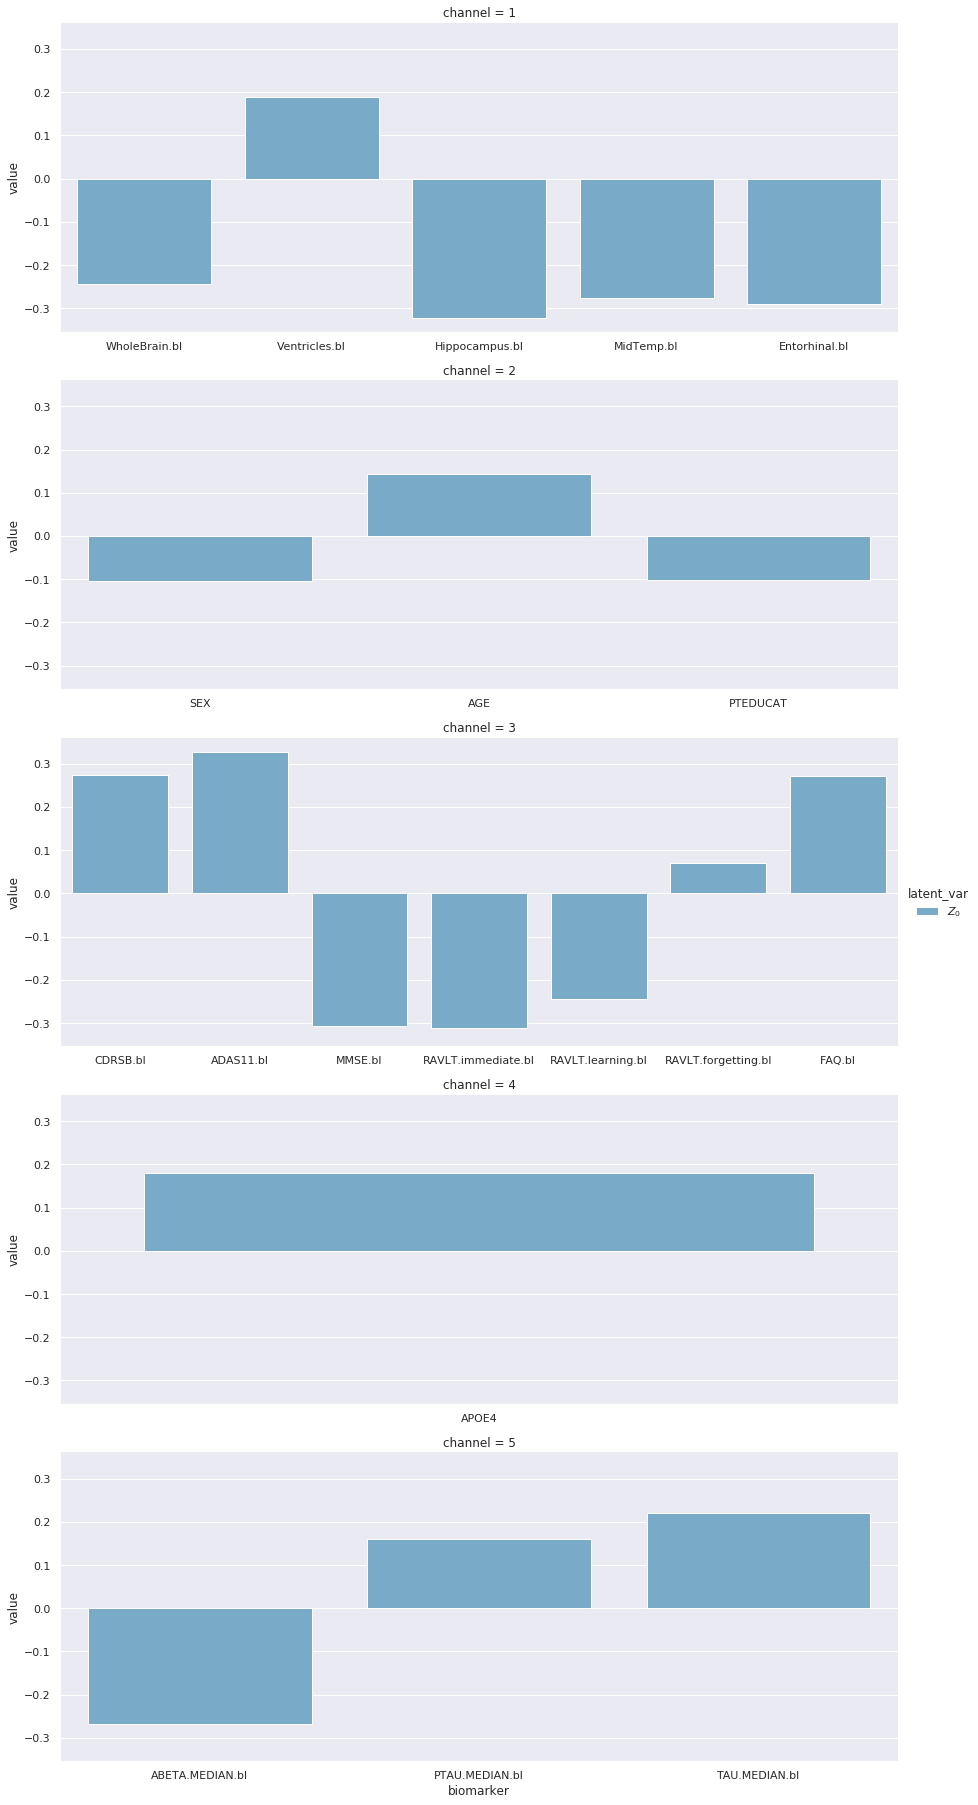

In [21]:
sns.catplot(data=weights_melt, x='biomarker', y='value', hue='latent_var', kind='bar', col='channel', col_wrap=1, aspect=2.5, sharex=False, palette='Blues_r')
plt.show()